# Machine learning - les 3

Notebook bij les 3 van de leerlijn machine learning van S3 - AI. 

© Auteur: Rianne van Os

**Voorbereiding voor deze les:**
Maak t/m opdracht 3.3. Lees ook de uitleg goed door.

In de vorige 2 machine learning lessen heb je verschillende modellen gebruikt voor classificatie, waarmee je een categorische variabele kunt voorspellen. In deze les gaan we gaan we kijken hoe je een continue variabele kunt voorspellen.



Stel je wilt je eigen woning aan gaan bieden op Airbnb. Dan kun je een groot deel van de gegevens die je nodig hebt om een profiel aan te maken zelf invullen. Maar wat zou een logische prijs zijn om te vragen per nacht?
Dit is een voorbeeld van een regressieprobleem. We willen op basis van een aantal variabelen (bijvoorbeeld het aantal slaapkamers, de locatie, de grootte van de woning) een continue waarde bepalen: namelijk de prijs. Net zoals bij de eerdere classificatie-problemen zou je dit kunnen doen door een model te trainen op de bekende data, en dat model vervolgens gebruiken om de huurprijs voor jouw woning te voorspellen.

In dit notebook behandelen we stap voor stap de technieken die nodig zijn voor het trainen van zo'n regressiemodel.


Eerst weer wat libraries importeren. Voeg hier zelf waar nodig imports aan toe.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Correlatie

Bij regressie gaat het dus om het voorspellen van een continue waarde. Een van de simpelste en meest voorkomende vormen van regressie is **Lineaire Regressie**, waarbij we een *lineair* verband zoeken tussen de features en de target. In 2-dimensies komt dit neer op een rechte lijn.

Laten we kijken naar een super simpel voorbeeldje. We maken een datasetje met de lengte en het gewicht van een paar mensen. In de data-lessen heb je al geleerd dat je het verband tussen 2 numerieke waarden kunt visualiseren met en scatterplot, dus dat doen we nu ook.


<Axes: xlabel='lengte', ylabel='gewicht'>

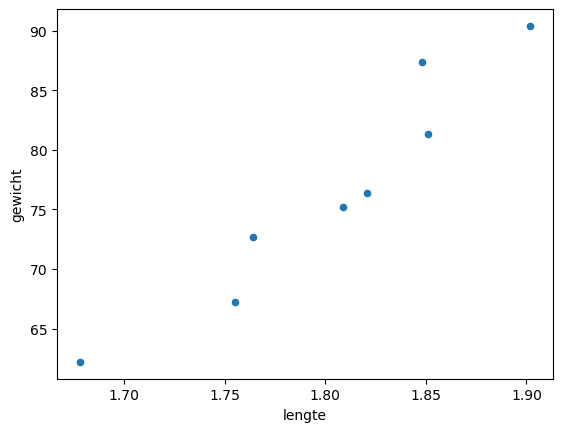

In [2]:
personen = pd.DataFrame({'lengte': [1.678, 1.755, 1.764, 1.821, 1.809, 1.851, 1.848, 1.902], 
                         'gewicht': [62.2, 67.2, 72.7, 76.4, 75.2, 81.3, 87.4, 90.4]})

personen.plot.scatter(x='lengte', y='gewicht')

We zien hier al dat er inderdaad een verband is tussen lengte en gewicht. Het gewicht neemt toe als de lengte toeneemt en op het oog zie je al dat er redelijk goed een rechte lijn door de punten te trekken is. De sterkte van dit verband kunnen we meten de **correlatiecoëfficient**. 
Dit is een maat om de samenhang tussen twee numerieke waarden te berekenen. De correlatiecoefficient is een getal tussen -1 en 1, waarbij een dichtbij 1 of -1 een sterk verband aangeeft tussen de twee variabelen. Een waarde van 0 betekent dat er geen lineair verband is.

Laten we de correlatie tussen lengte en gewicht uitrekenen:

In [3]:
personen['lengte'].corr(personen['gewicht'])

np.float64(0.9573607425326733)

We zien een correlatie van 0.957, wat betekent dat er een sterk lineair verband is tussen deze variabelen, wat betekent dat het goed mogelijk moet zijn om `gewicht` te voorspellen als je `lengte` weet. 

Zie hieronder nog een voorbeeld van verschillende correlatiecoefficiënten. (Bron: https://www.simplypsychology.org/correlation.html)

![corrcoef](./../afbeeldingen/MachineLearning/correlatiecoefficient.png "Correlatiecoefficient")

Een paar dingen die van belang zijn: 
- Als er een hoge correlatie tussen twee variabelen is, betekent dat niet dat de ene variabele de andere beinvloedt. Als de ene variabele de andere wel beinvloedt, dan zeggen we dat er een causaal verband is. In de statistiek is een bekende uitspraak: 'correlation is not causation'.  Bekijk deze pagina voor een paar goede voorbeelden hiervan. https://www.statology.org/correlation-does-not-imply-causation-examples/
- Als er een causaal verband bestaat tussen 2 variabelen. Denk altijd goed na over wat de afhankelijke en de onafhankelijke variabele is. Als er een correlatie is tussen weer en ijsverkoop, wordt het weer dan beinvloed door de ijsverkoop, of andersom? Het weer is hier logischerwijs de onafhankelijke variabele en de ijsverkoop de afhankelijke.
- Als er een correlatie is, kan het ook zijn dat er een andere variabele beide variabele beinvloed. Zo zijn lichaamslengte en schoenmaat van personen gecorreleerd, maar een variabele die beide waarden beïnvloed is de leeftijd van persoon. 
- Als er geen correlatie is tussen twee variabelen, betekent dat niet dat er geen verband is. Het betekent alleen dat er geen *lineair* verband is. Het verband kan bijvoorbeeld wel kwadratisch zijn (zie plaatje hieronder). Wel is het zo dat als er geen lineair verband is, je ook geen lineair regressie model kunt gebruiken.

De les uit deze punten: wees zeer voorzichtig met het trekken van conclusies als er wel of geen correlatie is. 

![niet lineair verband](./../afbeeldingen/MachineLearning/non_linear.png "Niet-lineair verband")

### ML Opdracht 3.1
Lees de dataset auto_mpg.csv in. Dit is een dataset met diverse kenmerken van auto's, die je kunt gebruiken om het gebruik van auto's te voorspellen. Kies 4 numerieke variabelen uit en bepaal de onderlinge correlaties. Welke verbanden vind je en lijken die je logisch?


### Lineaire regressie
Laten we nu maar eens kijen wat een lineair regressie model is. Een Lineair Regressie model probeert de relatie tussen de feature(s) en de target te modelleren met een rechte lijn. De formule voor een simpele lineaire regressie met één feature ($x$) en een target ($y$) is:

$y = ax + b$

Waarbij:
*   $y$: de voorspelde target waarde
*   $x$: de feature waarde
*   $a$: de *richtingscoëfficiënt* (of *slope*) - hoeveel $y$ verandert als $x$ met 1 toeneemt
*   $b$: het *intercept* - de voorspelde waarde van $y$ als $x=0$

Het doel van Lineaire Regressie is het vinden van de waarden voor $a$ en $b$ die de lijn zo goed mogelijk laten passen bij de data. 'Zo goed mogelijk passen' wordt meestal gedefinieerd als het zo klein mogelijk maken van de *Residual Sum of Squares (RSS)*: de som van de kwadraten van alle residuen, oftewel $$ \sum (y_{werkelijk} - y_{voorspeld})^2 $$ 

Hierbij staat het $\sum$-teken voor de som over alle $y$-waarden. Het zoeken naar de beste lijn door de kwadraten zo klein mogelijk te maken, heet de **kleinste kwadraten methode of Ordinary Least Squares, afgekort: OLS**.

Onderstaande plaatje helpt hopelijk bij het begrijpen van de residual sum of squares.

![rss](./../afbeeldingen/MachineLearning/rss.png "Residual Sum of Squares")

Hier zijn de blauwe punten de daadwerkelijke waarden en de zwarte lijn is de voorspelling van het model. Voor ieder punt wordt de afstand van de lijn naar het punt (de residu) gekwadrateerd en opgeteld. Het doel van het model is om de lijn zo te kiezen dat deze som zo klein mogelijk is.
De wiskundige formule voor deze som is:
$$ RSS = \sum_{i=1}^{n} (y_i - \hat{y_i})^2 $$
Hierbij is $y_i$ de werkelijke waarde van de target, en $\hat{y_i}$ de voorspelde waarde van de target. $n$ is het aantal datapunten.


### ML Opdracht 3.2: bepaal handmatig de beste coëfficienten
Gebruik onderstaande cellen met code om de *beste* lineaire formule te vinden het gewicht $y$ voorspelt gegeven de lengte $x. Deze formule is dan van de vorm $y=ax+b$, waarbij $a$ staat voor de richtingscoëfficient en $b$ voor de intercept.$a$ 

Je vindt de beste formule door de _sum of squared residuals_ (SSR, de som van het kwadraat van de residuen) te minimaliseren. Maak hiervoor gebruik van de grafiek die hieronder getekend wordt. De verticale rode lijnen representeren het residu bij elke meetwaarde.


- Tip 1: je kunt als eerste gok de richtingscoëfficient uitrekenen op basis van twee van de gegeven punten
- Tip 2: je kunt de helling van de lijn aanpassen met a
- Tip 3: je kunt de hoogte van de lijn aanpassen met b

In [4]:
# x-as loopt van minimum van lengte tot maximum van lengte
x = np.linspace((personen[['lengte']].min()-.03), personen[['lengte']].max()+.03)

In [5]:
# Geef hier de beste formule
a = 0 #vul hier een goede waarde voor a in
b = 0 #vul hier een goede waarde voor b in
y = a*x+b

C:\Users\mathi\AppData\Local\Temp\ipykernel_12616\3789880057.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = (x.max()-x.min())/(y.max()-y.min())


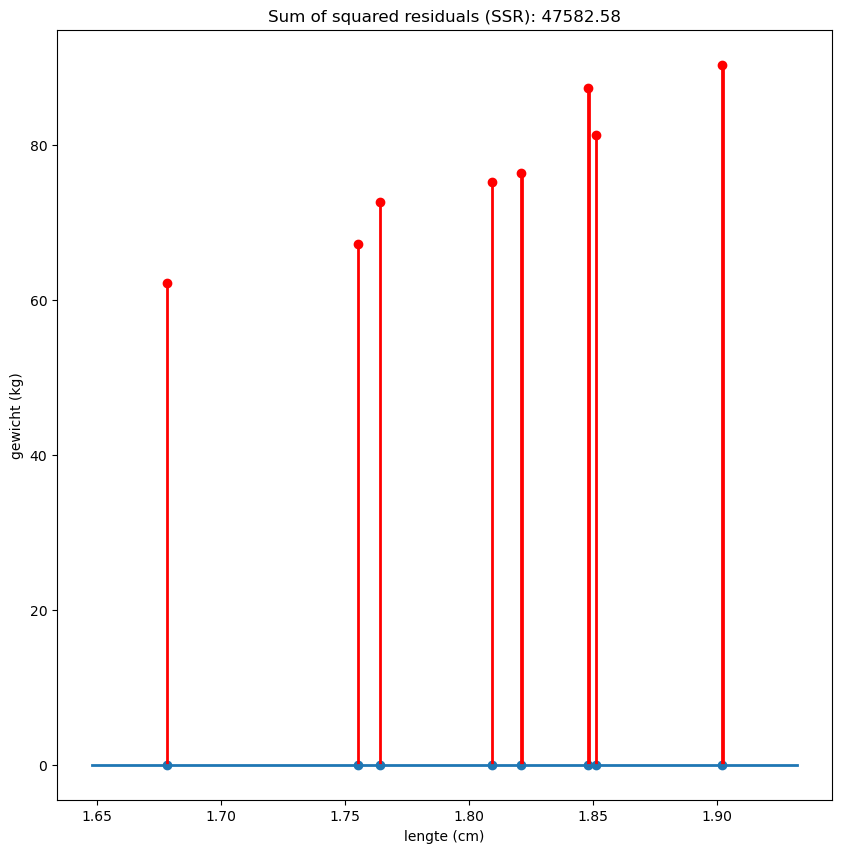

In [6]:
# Make predictions
personen['gewicht_voorspeld'] = a * personen[['lengte']] + b 
personen['residu'] = (personen['gewicht_voorspeld'] - personen['gewicht'])
personen['square'] = personen['residu']**2
ssr = personen['square'].sum()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

plt.title('Sum of squared residuals (SSR): {:.2f}'.format(ssr))
plt.xlabel('lengte (cm)')
plt.ylabel('gewicht (kg)')

ratio = (x.max()-x.min())/(y.max()-y.min())

ax.plot(x,y, linewidth=2)
ax.scatter(personen['lengte'], personen['gewicht_voorspeld'])
ax.scatter(personen['lengte'], personen['gewicht'], c='r')

# Create a Rectangle patch
for index, persoon in personen.iterrows():
    if ssr < 500:
        rect = patches.Rectangle((persoon['lengte'], persoon['gewicht']),
                                 persoon['residu']*ratio, persoon['residu'],
                                 linewidth=1,edgecolor='r', facecolor='r', alpha=.3)
        ax.add_patch(rect)
        
    rect = patches.Rectangle((persoon['lengte'], persoon['gewicht']),
                             0.00005, persoon['residu'],
                             linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

### Lineaire regressie met sklearn

Je zult merken dat het best lastig is om handmatig de *exacte* beste $a$ en $b$ te vinden. Dit minimalisatieprobleem (het vinden van de $a$ en $b$ die de SSR minimaliseren) is waar algoritmes voor Lineaire Regressie om de hoek komen kijken. Scikit-learn heeft een efficiënte implementatie die dit voor ons doet met de `LinearRegression` klasse, zie: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.

Hieronder zie je hoe je dit toe kunt passen op dit voorbeeldje. 

In [7]:
#Maak een linear regressie object aan
lin_reg_model = LinearRegression()
#Bepaal feature en target variabelen
X = personen[['lengte']]
y = personen[['gewicht']]
#Fit het model
lin_reg_model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Dit object bevat nu de parameters $a$ en $b$ die de beste lijn door de punten weergeeft. We kunnen deze bekijken:

In [8]:
# de richtingscoefficient:
lin_reg_model.coef_

array([[131.68424775]])

In [9]:
#de intercept:
lin_reg_model.intercept_

array([-160.89254081])

### Opdracht 3.3
a. Vul deze waarden in de code van opdracht 3.2 in en bepaal de bijbehorende RSS.

b. Net als bij een classificatiemodel heeft het lineaire regressie model ook een .predict() functie. Gebruik die om het gewicht te bepalen van iemand met een lengte van 1.80.

**Merk op:** We hebben nu geen train/test split gebruikt omdat we enkel op zoek waren naar de beste lijn door de gegeven punten. Als je een voorspellend model wilt maken en je wilt weten hoe goed dit zal preseteren op nieuwe, ongeziene data, zul je net als bij een classificatie model eerst een train/test(/val) split uit moeten voeren.

### Evaluatie van een regressie model

In de vorige les heb je gezien dat je de kwaliteit van een classificatie-model kon bepalen aan de hand van de *accuracy*. Dit is het percentage correcte voorspellingen. Bij een regressiemodel zijn we niet zozeer geinteresseerd in een precies voorspelling (dat is namelijk vaak onmogelijk bij een continue variabele), maar wil je een model vinden waarvan de voorspelling zo min mogelijk van de echte waardes af zit. We hebben net al de Residual Sum of Squares bekeken, maar het vreemde hieraan is, is dat die toeneemt als je meer datapunten hebt. Voeg maar eens een paar datapunten toe aan het personen dataframe en kijk wat er gebeurt met de RSS.

Logischer is het om de evaluatie metric onafhankelijk te maken van het aantal rijen in je dataset. Dat kun je doen door deze RSS te delen door het aantal datapunten, dan krijg je wat we noemen de *mean squared error*, oftewel de *MSE*. 

Een voorbeeld: 
De lijn $y = 130 a - 160$ heeft de volgende RSS op de personen dataset: 

In [10]:
#bepaal de voorspelling
gewicht_voorspeld = 130*personen['lengte'] -160
#bereken de residuen
personen['residu'] = gewicht_voorspeld - personen['gewicht']
#bereken de som van de kwadraten van de residuen
np.sum(personen['residu']**2)

np.float64(90.49440000000018)

Omdat we de som van alle residuen nemen, hangt deze maat af van de grootte van de dataset. Dat is niet logisch, en daarom is een andere *evaluation metric* beter, namelijk de *mean squared error*. De formule hiervoor is:
$$ MSE  = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2 $$

Hierbij delen de we RSS door het aantal datapunten, zodat de maar niet meer afhankelijk is van de grootte van de dataset.

In het voorbeeld geeft dit een MSE van:

In [11]:
1/len(personen) * np.sum(personen['residu']**2)

np.float64(11.311800000000023)

Deze MSE geeft nu de gemiddelde gekwadrateerde fout per datapunt weer, die dus onafhankelijk is van de grootte van je dataset. De eenheid van MSE is echter het kwadraat van de eenheid van de target variabele (bijv. gewicht in het kwadraat), wat de interpretatie lastig kan maken. Daarom is de meest gebruikte *evaluation metric* voor regressieproblemen de Root Mean Squared (RMSE). Dit is de wortel van de MSE, zodat de eenheid weer gelijk is aan die van de target.

In ons voorbeeld:

In [12]:
RMSE = np.sqrt(np.sum(personen['residu']**2)/len(personen))
RMSE

np.float64(3.3633019489781204)

Dit betekent dat een punt op de lijn $y=130x - 160$ gemiddeld 3.4 kg afwijkt van het daadwerkelijke gewicht. 

**Note:**
Een andere *evaluation metric* voor de evaluatie van een regressiemodel is R-squared. Dit getal geeft weer welk deel van de variantie in de target variabele verklaard wordt door het model. Deze ligt tussen 0 en 1, waarbij 1 een perfecte fit betekent (dus een RMSE van 0). We gaan nu niet dieper op deze maat in, maar je zult dit tegen kunnen komen in de literatuur.

### ML Opdracht 3.4
We gaan nu onderzoeken hoe goed we het verbruik van auto's kunnen voorspellen aan de hand van diverse kenmerken. Lees daarvoor de dataset auto_mpg.csv in. We willen hier de variabel miles per gallion (mpg) kunnen voorspellen op basis van de andere features. Doe hiervoor het volgende:
- Maak een dataframe met de features en de target. Gebruik voor de features enkel de numerieke variabelen. De target is mpg.
- Split de dataset in een train- en testset. Houdt de testset apart en ga verder met de trainset:
- Bepaal voor iedere feature variabele de correlatie met de target variabele.
- Train een lineair regressie model met de features die een (relatief) hoge correlatie hebben met mpg.
- Bepaal de RMSE op de test-set.

### Het effect van outliers op je model

We hebben eerder al gezien wat het effect van outliers kan zijn op het doen van analyses of het maken van visualisaties, maar outliers kunnen ook een sterk effect hebben op de resultaten van een machine learning model. 

Om dit te illustreren voegen we een extreem zwaar persoon toe aan de personen dataset:



In [13]:
zwaar_persoon = pd.DataFrame({'lengte': [1.65], 'gewicht' : [150]})
personen_met_outlier = pd.concat([personen, zwaar_persoon], ignore_index=True)

### ML Opdracht 3.5
- Maak een scatterplot van de data en beschrijf hoe je hier de outlier in terug ziet.
- Train een lineair regressiemodel op de gehele dataset.
- Verwijder de outlier en train een nieuw model op de data.
- Maak een visualisatie waarin de gevonden modellen (dus de lijnen door de data) weergegeven worden. Hoe zie je het effect van de outlier hierin terugkomen?
- Bereken de RMSE van beide modellen. Hoeveel verschil zit er tussen de twee modellen?

Merk op dat een enkele outlier van grote invloed kan zijn op de gevonden regressielijn. De outlier is misschien wel een valide datapunt (de persoon met een lengte van 1.65 en een gewicht van 150 kg kan echt bestaan), maar je kunt je toch afvragen of het wenselijk is om dit mee te nemen in je model. Je model gaat namelijk slechter voorspellen op data die vaker voorkomt. Dit zijn afwegingen die je in overleg met de opdrachtgever moet maken.

### Omgaan met missing values bij het trainen van een model

Naast outliers in je data, kunnen ook *missing values* het trainen van een model bemoeilijken. Hierbij is het probleem dat een model niet met missende waarden in de trainset om kunnen gaan. Je zult deze dus in de data preparatiestap weg moeten halen. Hiervoor heb je verschillende mogelijkheden:
1. Kolommen met missende waarden verwijderen
2. Rijen met missende waarden verwijderen
3. De missende waarden vervangen door een andere waarde (bijvoorbeeld de gemiddelde waarde van de kolom)

Kolommen met erg veel missende waarden kun je wel verwijderen, want die geven waarschijnlijk toch weinig informatie. Maar vaak is het zo dat er, ondanks een aantal missende waarde, veel informatie in de kolom zit en dan wil je deze dus niet verwijderen. Ook als je rijen met missende waarden verwijdert, moet je je afvragen of je niet te veel informatie verliest. En je krijgt dan nog een tweede probleem: als je een model traint op de data zonder missende waarden, kun je deze niet gebruiken om voorspellingen te doen op nieuwe data met missende waarden.

Vaak is het dus beter om de missende waarden te vervangen door een andere waarde. Dit is vaak het gemiddelde, de mediaan of de modus van de kolom. Ook kun je het gemiddelde voor een bepaalde groep gebruiken. Bijvoorbeeld: als je een dataset hebt met de leeftijd van mensen, kun je het gemiddelde van de leeftijd per geslacht gebruiken om de missende waarden in te vullen. 
In de praktijk ga je vaak een aantal technieken proberen en kijken wat het beste model oplevert. 

## Decision Tree Regressor

Naast een Lineaire Regressie model zijn er nog meer modellen die je kunt gebruiken om een continue waarde te voorspellen. Een veel gebruikt model is de Decision Tree Regressor. Hier vindt je een goede uitleg daarover: https://farshadabdulazeez.medium.com/understanding-decision-tree-regressor-an-in-depth-intuition-a1d3af182efd en hier vind je uitleg op youtube: https://www.youtube.com/watch?v=UhY5vPfQIrA
 
Deze Decision Tree Regressors zijn uiteraard ook weer te combineren tot een Random Forest Regressor, een populair regressiemodel. Een groot voordeel van dit model is dat er niet per se een lineaire relatie hoeft te zijn tussen de features en de target om een goed presterend model te krijgen. Ook is een Decision Tree minder gevoelig voor outliers dan een Lineair Regressie model (kun je bedenken waarom?).


### ML Opdracht 3.6
Bekijk de dataset `insurance.csv` in. Dit is een dataset met informatie over verzekerden en hun claims. Deze dataset bevat de volgende features:
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance We willen hier de `charges` kunnen voorspellen op basis van de andere features.

We willen hier de `charges` kunnen voorspellen op basis van de andere features. Deze dataset komt van kaggle, maar is iets aangepast voor deze opdracht.